## 02 Bounding Box Detection

- Image classification is a great starting point for deep learning, an despite it's relative simplicity, can be incredibly useful. 
- However, for many applications, it's simply not enough to know *what's* in an an image, we also need to know *where*
- One of most popular ways to both classify and localize objects in image using deep learning is with **bounding box detection models**. 
- Let's see if we can get one together!

In [82]:
import warnings, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from utils import *

## 1. Data

- As usual, we'll start by getting some data. 
- We'll have to do a bit of data wrangling to get our labels into good shape

In [8]:
data_dir=Path('data/')
dataset_name='screw'
get_mvtech_dataset(data_dir, dataset_name)

In [10]:
list((data_dir/dataset_name).glob('*'))

[PosixPath('data/screw/test'),
 PosixPath('data/screw/train'),
 PosixPath('data/screw/readme.txt'),
 PosixPath('data/screw/license.txt'),
 PosixPath('data/screw/ground_truth')]

- Let's have a look at our labels

In [12]:
list((data_dir/dataset_name/'ground_truth').glob('*'))

[PosixPath('data/screw/ground_truth/scratch_neck'),
 PosixPath('data/screw/ground_truth/scratch_head'),
 PosixPath('data/screw/ground_truth/thread_side'),
 PosixPath('data/screw/ground_truth/thread_top'),
 PosixPath('data/screw/ground_truth/manipulated_front')]

In [14]:
list((data_dir/dataset_name/'ground_truth'/'scratch_neck').glob('*'))[:5]

[PosixPath('data/screw/ground_truth/scratch_neck/007_mask.png'),
 PosixPath('data/screw/ground_truth/scratch_neck/013_mask.png'),
 PosixPath('data/screw/ground_truth/scratch_neck/008_mask.png'),
 PosixPath('data/screw/ground_truth/scratch_neck/001_mask.png'),
 PosixPath('data/screw/ground_truth/scratch_neck/019_mask.png')]

- Our labels come to us in the form of segmentation masks
- let's see if we can massage these into bounding boxes :)

In [16]:
masks=list((data_dir/dataset_name/'ground_truth'/'scratch_neck').glob('*'))

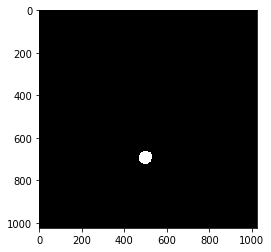

In [27]:
im=cv2.imread(str(masks[0]))
plt.imshow(im)

- Alright, here we have a mask!
- Let's find our corresponding image and see if it makes any sense. 

In [33]:
all_classes=[p.name for p in (data_dir/dataset_name/'test').glob('*')]

In [34]:
classes

['scratch_neck',
 'scratch_head',
 'thread_side',
 'thread_top',
 'manipulated_front',
 'good']

In [46]:
c=classes[0]
im_paths={int(p.name.split('.')[0]):p for p in (data_dir/dataset_name/'test'/c).glob('*')}
mask_paths={int(p.name.split('_')[0]):p for p in (data_dir/dataset_name/'ground_truth'/c).glob('*')}

In [64]:
i=1
im=cv2.cvtColor(cv2.imread(str(im_paths[i])), cv2.COLOR_BGR2RGB)
mask=cv2.imread(str(mask_paths[i]))

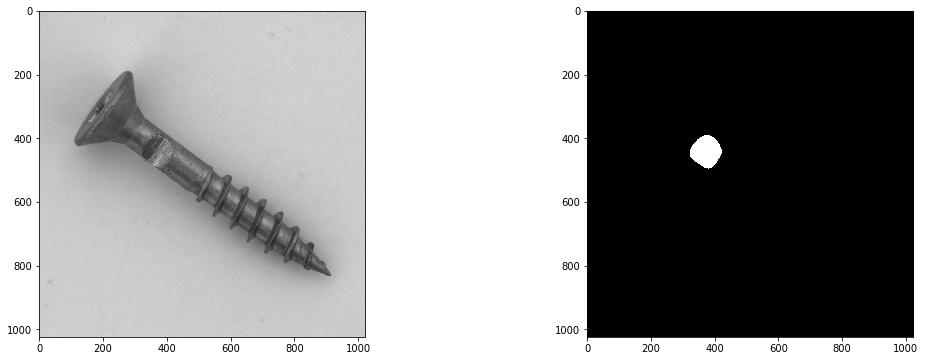

In [65]:
fig=plt.figure(0, (18,6))
fig.add_subplot(1,2,1); plt.imshow(im)
fig.add_subplot(1,2,2); plt.imshow(mask)

- Alright, now we're getting somewhere!
- Now, let's see if we can turn out mask into a bounding box.

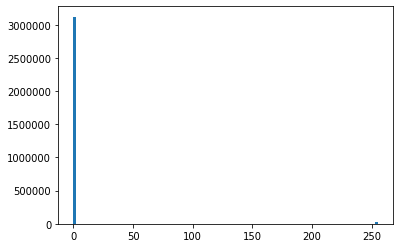

In [68]:
plt.hist(mask.ravel(), 100);

In [73]:
np.unique(mask.ravel())

array([  0, 255], dtype=uint8)

In [112]:
def mask2bbox(mask, region_value=255):
    x,y=np.where(mask==region_value)
    return [np.min(x), np.min(y), np.max(x), np.max(y)]

In [113]:
bbox=mask2bbox(mask[:,:,0]); bbox

[642, 30, 689, 112]

In [91]:
def draw_image_and_bbox(im, bbox, fig=None, ax=None):
    if fig is None: fig=plt.figure(0, (8,8)); 
    if ax is None: ax=fig.add_subplot(111)
    ax.imshow(im)
    ax.add_patch(patches.Rectangle((bbox[0],bbox[2]),bbox[1]-bbox[0],bbox[3]-bbox[2], \
                                   linewidth=2, edgecolor='m', facecolor='none'))

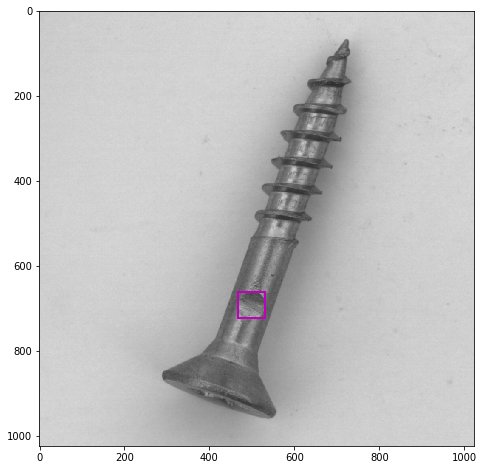

In [92]:
draw_image_and_bbox(im, bbox)

- Alright, not bad, right? 
- Let's look at a few more. 

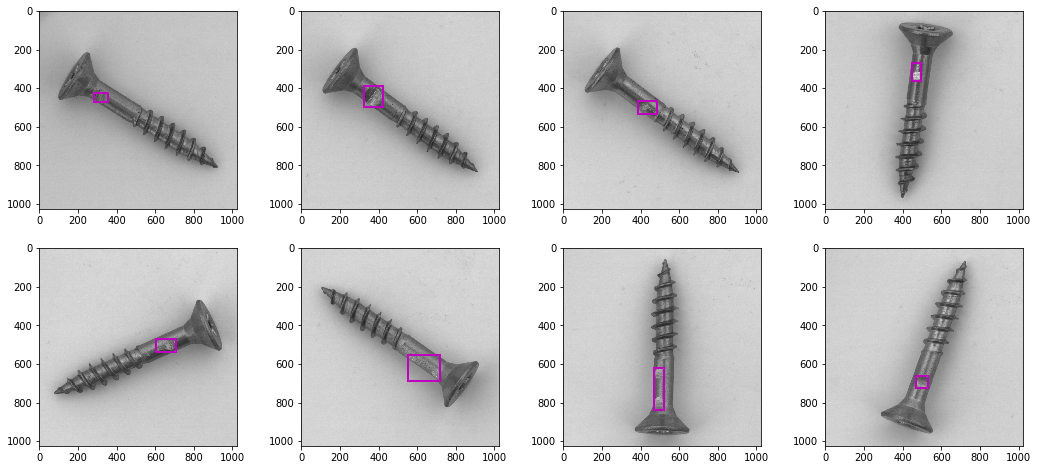

In [93]:
fig=plt.figure(0, (18,8))
for i in range(8):
    im=cv2.cvtColor(cv2.imread(str(im_paths[i])), cv2.COLOR_BGR2RGB)
    mask=cv2.imread(str(mask_paths[i]))
    bbox=mask2bbox(mask[:,:,0])
    ax=fig.add_subplot(2,4,i+1)
    draw_image_and_bbox(im, bbox, ax=ax)

## 2. Staging Data for Deep Learning Model

- So, we can visualize our data, but what about feeding it into our deep learning model?
- How do we setup our labels in a way that our model can learn from them??

In [114]:
from fastai.vision import *

In [115]:
image_paths=[]
lbl_bbox=[]
for c in classes:
    im_paths={int(p.name.split('.')[0]):p for p in (data_dir/dataset_name/'test'/c).glob('*')}
    mask_paths={int(p.name.split('_')[0]):p for p in (data_dir/dataset_name/'ground_truth'/c).glob('*')}
    for i in range(len(mask_paths)):
        image_paths.append(im_paths[i])
        mask=cv2.imread(str(mask_paths[i]))
        bbox=mask2bbox(mask[:,:,0])
        lbl_bbox.append([[bbox], [c]])

In [132]:
len(image_paths), len(lbl_bbox)

(119, 119)

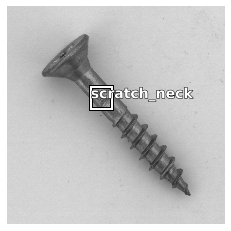

In [119]:
i=10
img = open_image(image_paths[i])
bbox=ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

In [127]:
img2bbox = dict(zip([p.name for p in image_paths], lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [128]:
img2bbox

{'000.png': [[[856, 163, 940, 260]], ['manipulated_front']],
 '001.png': [[[829, 785, 913, 860]], ['manipulated_front']],
 '002.png': [[[914, 462, 1014, 505]], ['manipulated_front']],
 '003.png': [[[283, 54, 360, 156]], ['manipulated_front']],
 '004.png': [[[93, 763, 183, 818]], ['manipulated_front']],
 '005.png': [[[882, 653, 979, 738]], ['manipulated_front']],
 '006.png': [[[786, 105, 867, 197]], ['manipulated_front']],
 '007.png': [[[711, 69, 776, 194]], ['manipulated_front']],
 '008.png': [[[41, 376, 149, 465]], ['manipulated_front']],
 '009.png': [[[751, 115, 861, 247]], ['manipulated_front']],
 '010.png': [[[882, 399, 980, 464]], ['manipulated_front']],
 '011.png': [[[255, 869, 318, 962]], ['manipulated_front']],
 '012.png': [[[925, 419, 992, 466]], ['manipulated_front']],
 '013.png': [[[809, 813, 893, 878]], ['manipulated_front']],
 '014.png': [[[84, 194, 164, 261]], ['manipulated_front']],
 '015.png': [[[546, 30, 625, 146]], ['manipulated_front']],
 '016.png': [[[789, 381, 968,

In [129]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(data_dir/dataset_name/'test')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [130]:
data = get_data(bs=64,size=256)

KeyError: '034.png'